This block just imports the potential_fitting module.

In [1]:
import potential_fitting

Now define filepaths as variables so we don't have to keep retyping strings.
Make sure you have nothing of value in any of these files, as all files will be overwritten by certain steps of the workflow except settings, unopt_geo, and database.

In [2]:
settings = "H2Omonomer.ini"
unopt_geo = "H2O.xyz"
opt_geo = "H2O.opt.xyz"
normal_modes = "normal_modes.dat"
train_configs = "train_configs.xyz"
test_configs = "test_configs.xyz"
database = "H2Odatabase.db"
training_set = "training_set.xyz"
test_set = "test_set.xyz"
poly_in = "poly.in"
molecule_in = "A2B1"
poly_directory = "poly"
config = "config.ini"
fit_directory = "fit"
fitted_code = "fitted"

Optimizes the single geometry specified in the file located at the path specifed by unopt_geo and writes the optimized geometry to the file path specified by opt geo. This may take a while depending on what method/basis you use.

In [3]:
potential_fitting.optimize_geometry(settings, unopt_geo, opt_geo)

Beginning geometry optimization using psi4 of H2O with HF/STO-3G.
Optimizer: Optimization complete!
Completed geometry optimization.


Does a frequency calculation on the optimized geometry in the file located at the opt_geo path in order to generate a normal modes input file for the normal distribution configuration generator in the file located at normal_modes. dim_null (3 times number of atoms minus number of normal modes) is returned and should be used as input for the next function call. This may take a while depending on what method/basis you use.

In [4]:
potential_fitting.generate_normal_modes(settings, opt_geo, normal_modes)

Beginning normal modes calculation using psi4 of H2O with HF/STO-3G.
Normal mode/frequency analysis complete. 3 normal modes found.


6

Uses the optimized geometry specified by opt_geo and the normal modes data file specified by normal_modes to generate a number of 1b configurations in the file specified by configs. dim_null is the return value of the above step.

In [5]:
potential_fitting.generate_1b_configurations(settings, opt_geo, normal_modes, train_configs, seed = 3)
potential_fitting.generate_1b_configurations(settings, opt_geo, normal_modes, test_configs, seed = 2)

Parsing normal mode input file.
Completed parsing normal modes input file.
Running normal distribution configuration generator...
Normal Distribution Configuration generation complete.
Parsing normal mode input file.
Completed parsing normal modes input file.
Running normal distribution configuration generator...
Normal Distribution Configuration generation complete.


This puts the configurations located in the file specified by configs into the database specified by database. It will initialize the database if it does not already exist, if it exists, new configurations will be added from the configs file. Model, basis, and cp to be used to calculate energy are also set at this time as specifed in the settings file. Note that cp (counterpoise correction) has no effect for 1b systems. The second call adds the optimized geometry to the database.

In [6]:
potential_fitting.init_database(settings, database, train_configs, tag = 'train')
potential_fitting.init_database(settings, database, opt_geo, tag = 'train')
potential_fitting.init_database(settings, database, test_configs, tag = 'test')
potential_fitting.init_database(settings, database, opt_geo, tag = 'test')


Initializing database from xyz files in train_configs.xyz directory into database H2Odatabase.db
Initializing of database H2Odatabase.db successful
Initializing database from xyz files in H2O.opt.xyz directory into database H2Odatabase.db
Initializing of database H2Odatabase.db successful
Initializing database from xyz files in test_configs.xyz directory into database H2Odatabase.db
Initializing of database H2Odatabase.db successful
Initializing database from xyz files in H2O.opt.xyz directory into database H2Odatabase.db
Initializing of database H2Odatabase.db successful


Loops through every uncalculated energy in the database and calculates it. This will take a while depending on what method/basis you use.

In [7]:
potential_fitting.fill_database(settings, database)

Filling database H2Odatabase.db
     1     2     3     4     5     6     7     8     9    10
    11    12    13    14    15    16    17    18    19    20
    21    22    23    24    25    26    27    28    29    30
    31    32    33    34    35    36    37    38    39    40
    41    42    43    44    45    46    47    48    49    50
    51    52    53    54    55    56    57    58    59    60
    61    62    63    64    65    66    67    68    69    70
    71    72    73    74    75    76    77    78    79    80
    81    82    83    84    85    86    87    88    89    90
    91    92    93    94    95    96    97    98    99   100
   101   102   103   104   105   106   107   108   109   110
   111   112   113   114   115   116   117   118   119   120
   121   122   123   124   125   126   127   128   129   130
   131   132   133   134   135   136   137   138   139   140
   141   142   143   144   145   146   147   148   149   150
   151   152   153   154   155   156   157   158   15

Generates a training set in the file specified by training_set from all "H2O" (molecules with the name "H2O") energies in the database, additional arguments can be added to prune by method, basis, cp, or tag. If your database contains energies computed with a variety of methods/bases, it is probably a good idea to use only one of them in your training set at a time. The training set contains each configuration's deformation energy. The optimized geometry will have energy 0.

In [8]:

potential_fitting.generate_1b_training_set(settings, database, training_set, "H2O", tag = 'train')
potential_fitting.generate_1b_training_set(settings, database, test_set, "H2O", tag = 'test')


Creating a fitting input file from database H2Odatabase.db into file training_set.xyz
Generated training set with 101 Configurations.
Creating a fitting input file from database H2Odatabase.db into file test_set.xyz
Generated training set with 101 Configurations.


This call generates a polynomial input file based on the symmetry of molecule "H2O" in the database, it will be generated in the current working directory

In [10]:
potential_fitting.generate_poly_input_from_database(settings, database, "H2O", poly_in)

Generate polynomials of degree 3 based on the polynomial input file as specified by poly_in (should be the file created by the above call, will be symmetry as specified in settings file + ".in" for 1b) in the directory specified by poly_directory

In [13]:
potential_fitting.generate_polynomials(settings, poly_in, 3, poly_directory)

[[[0, 1, 2], [1, 0, 2]]]


Convert the polynomial maple files in poly_directory into cpp files

In [14]:
potential_fitting.execute_maple(settings, poly_directory)

Does a qchem calculation to generate the config file containing charges, polarizabilities, etc in the file specified by config based on the molecule symmetry specified by molecule_in (same as polynomial input but without the .in) and the optimized geometry as specified by opt_geo. This will take a while, but should not be effected by your method/basis.

In [3]:
potential_fitting.generate_fit_config(settings, molecule_in, config, opt_geo)

Generates the 1b fit code of degree 3 in fit_directory using the config file specified by config, and the polynomial files in poly_directory

In [18]:
potential_fitting.generate_1b_fit_code(settings, config, molecule_in, poly_in, poly_directory, 3, fit_directory)

Executing python generator script


Compile the fit code in fit_directory

In [19]:
potential_fitting.compile_fit_code(settings, fit_directory)

Generate a fitted .nc file at location "fit.nc" using the fit code in fit_directory, the training set as specified by training_set, and the fitcode as specified by fit_directory + "/fit-1b".

In [24]:
potential_fitting.fit_1b_training_set(settings, fit_directory + "/fit-1b", training_set, fit_directory, "fit.nc")

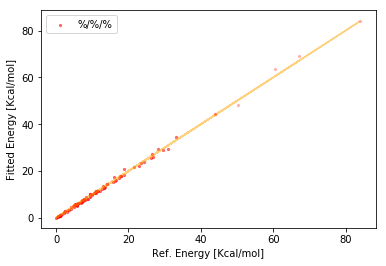

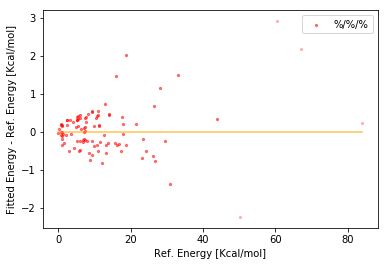

In [3]:
potential_fitting.fitting.fit_visualizer.make_1b_graphs(fit_directory + "/eval-1b", "fit.nc", database, "H2O", "%", "%", "%", "test")